In [1]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model
import os
import cv2
import imghdr

# from tensorflow.keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

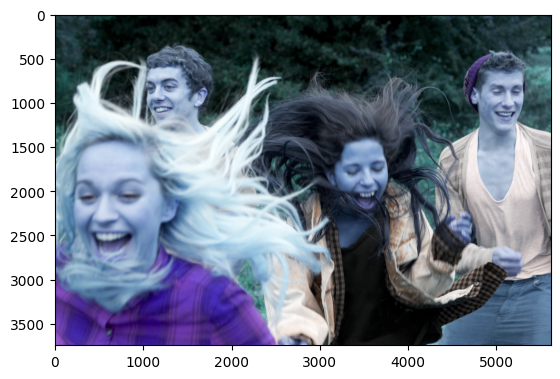

In [2]:
# load ur Image
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

In [3]:
# load old model
new_model = load_model('models\imageclassifier.h5')

In [4]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [5]:
# print all layers
for i in new_model.layers:
    print(i.name,sep='\n')

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense
dense_1


In [14]:
new_model.layers[0].get_weights()[1]

array([-0.00334818,  0.02599264, -0.00182788, -0.02391098,  0.01373995,
       -0.01711692, -0.01184611, -0.00320478,  0.0188906 , -0.00563345,
        0.00975752, -0.02287445, -0.006978  ,  0.0007102 ,  0.02011112,
       -0.01456458], dtype=float32)

In [7]:
layer_outputs = [layer.output for layer in new_model.layers] 
# Extracts the outputs of the top 12 layers
activation_model = Model(inputs=new_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [8]:
new_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'conv2d_input')>

In [9]:
layer_outputs

[<KerasTensor: shape=(None, 254, 254, 16) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 127, 127, 16) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 125, 125, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 62, 62, 32) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 60, 60, 16) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 30, 30, 16) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 14400) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>]

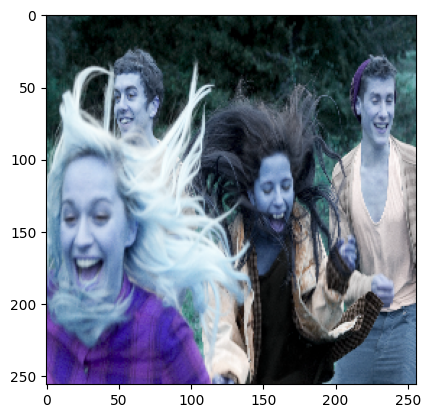

In [10]:
resize = tf.image.resize(img, (256,256)) # resize
plt.imshow(resize.numpy().astype(int))
plt.show()

In [11]:
activations = activation_model.predict(np.expand_dims(resize/255, 0)) 

1/1 [==============================] - 0s 138ms/step


# Display All conv2d activations

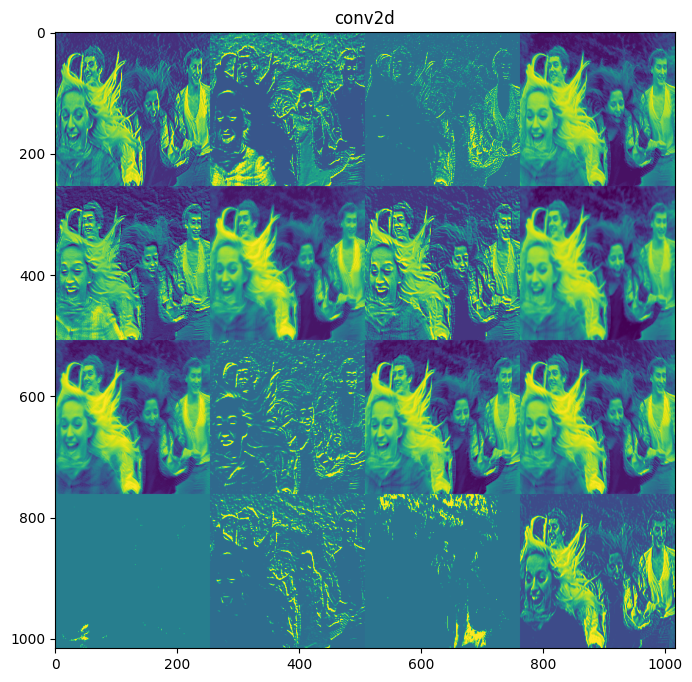

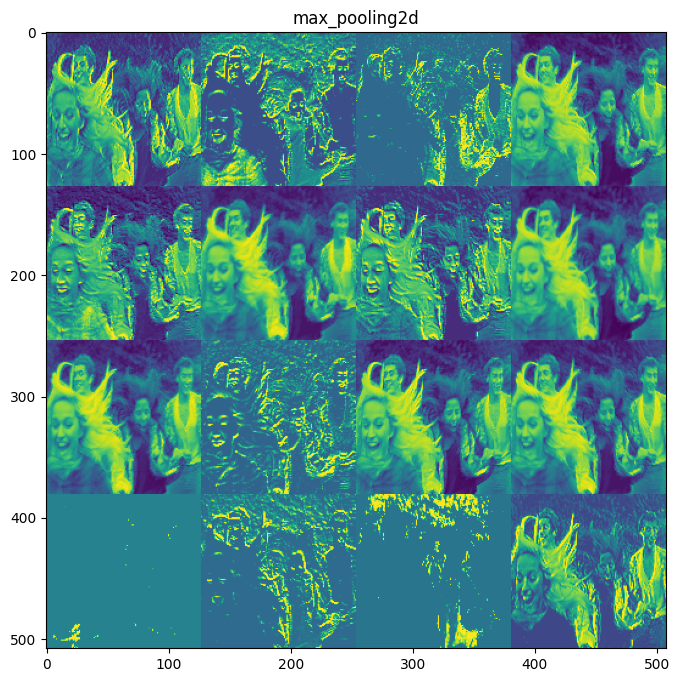

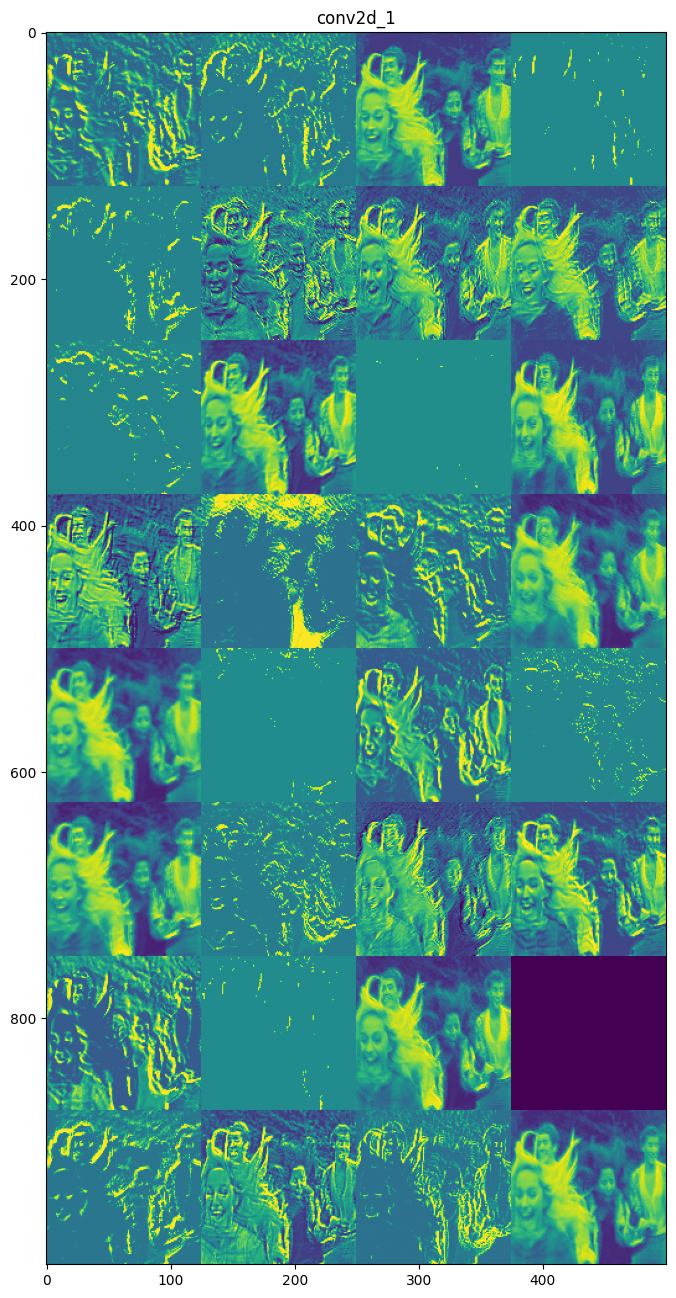

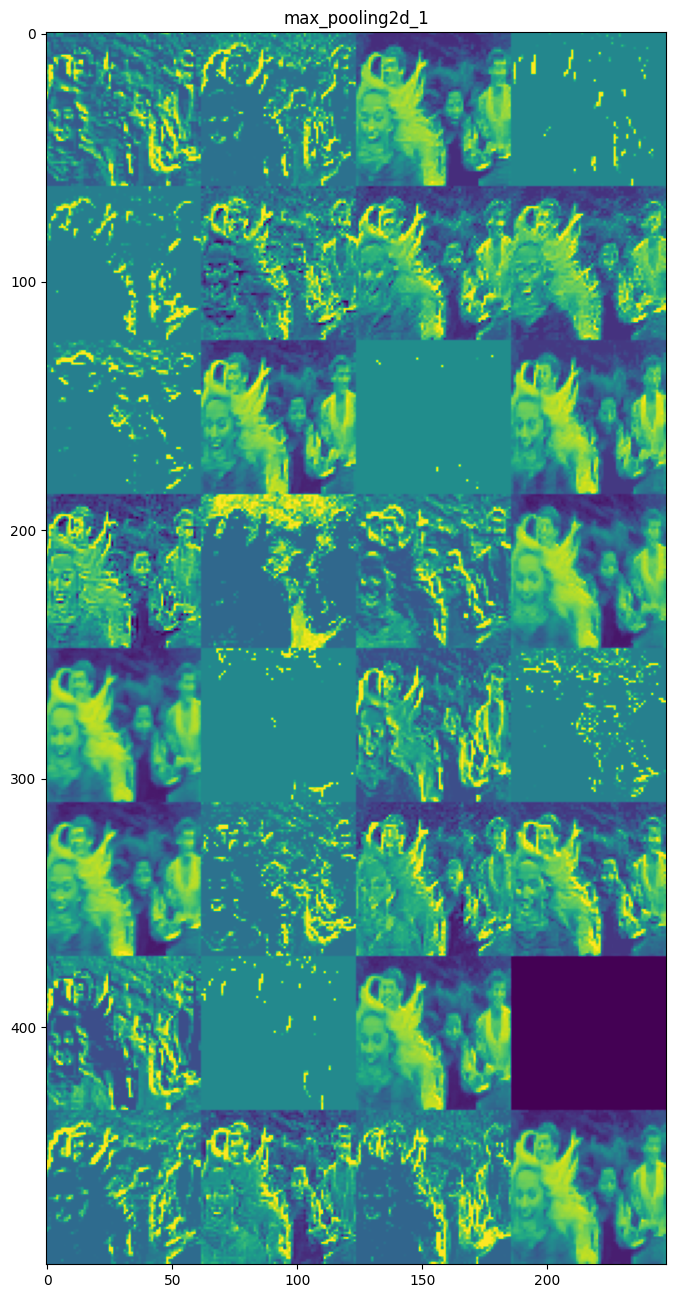

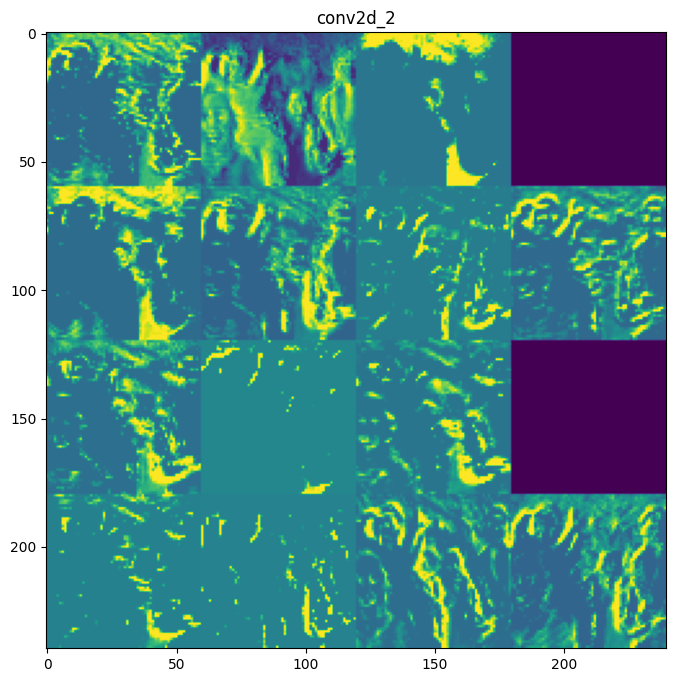

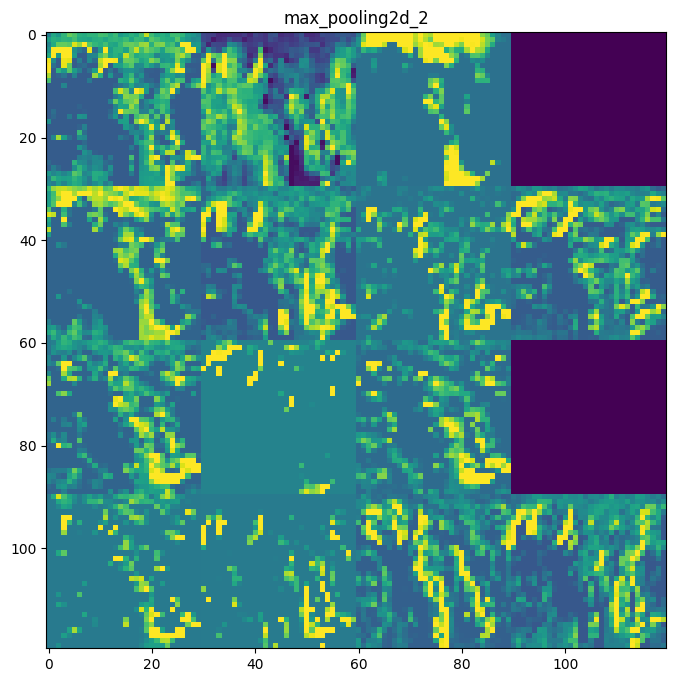

In [28]:
layer_names = []
for layer in new_model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 4

n = 0
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    
    if n in (0,1,2,3,4,5): # consider only conv layer
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 2. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
    n = n + 1